Строим решение с границами и суперпозицией

In [1]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

import welltest.functions as wf

In [2]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    # при расчете убедимся, что td=0 не повлияет на расчет, даже если td массив и нулевой только один элемент
    td = np.array(td, dtype = float)
    return np.multiply(-0.5, 
                       expi(np.divide(-rd**2 / 4 , 
                                      td, 
                                      out=np.zeros_like(td), where=td!=0)), 
                       out=np.zeros_like(td), where=td!=0)


# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_lapl_circle_closed(u, rd=1, r_ed=1000):
    """
    расчет решения в пространстве Лапласа для замкнутой круговой границы
    u -  переменная пространства Лапласа
    r_ed - безразмерный радиус контура
    """
    sqrtu = u ** 0.5
    r_ed_sqrtu = r_ed * sqrtu
    
    pd = (( kn(0, sqrtu) / (u*sqrtu*kn(1,sqrtu)) ) /
         (1 - kn(1, r_ed_sqrtu) / iv(1, r_ed_sqrtu) * iv(1, sqrtu)/kn(1, sqrtu) ) - 
         ( iv(0, sqrtu) / (u*sqrtu*iv(1,sqrtu)) ) /
         (1 - iv(1, r_ed_sqrtu) / kn(1, r_ed_sqrtu) * kn(1, sqrtu)/iv(1, sqrtu) ))
    return pd

# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_finite_rw(u, rd=1):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    return 1 / u**(3/2) * kn(0, rd * u**0.5) / kn(1, u**0.5)

In [3]:
# решение линейного стока в пространстве Лапласа
def pd_lapl_wbs(pd_lapl, S=0, Cd=0):
    def pdl(u, rd=1, S=S, Cd=Cd):
        return 1 / u * (S + u * pd_lapl(u, rd=rd)) / (1 + u * Cd * (S + u * pd_lapl(u, rd=rd)))
    return pdl

In [8]:
# построим функцию инвертирующую решение в пространстве Лапласа

# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_inv(pd_lapl, td, rd, **kwargs):
     
    pd_inv_ = get_lap_inv(pd_lapl, rd=rd, **kwargs)
    return pd_inv_(td)

In [9]:
def pd_circle_closed(td, rd=1, r_ed=1000, S=0, Cd=0):
    td1 = np.where(td<1e-3, 1e-3,td)
    return pd_inv(pd_lapl_wbs(pd_lapl_circle_closed),td=td1, rd=1, S=S, Cd=Cd)

pd_circle_closed_vector = np.vectorize(pd_circle_closed)

In [10]:
def pd_superposition(td, td_hist, qd_hist, **kwargs):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([0, qd_hist])
    tdh = np.hstack([0, td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([0, np.diff(qdh)])
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    # используем куммулятивную сумму numpy для того что суммировать результаты
    dpd = np.cumsum(qd_v * pd_circle_closed_vector((td_v - tdh)) * np.heaviside((td_v - tdh), 1),1 )
    # последний столбец - полная сумма, которая нужна в качестве результата
    return dpd[:,-1]

def q_superposition(t, t_hist, q_hist):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    def interpolate_constant(x, xp, yp):
        indices = np.searchsorted(xp, x, side='right')
        y = np.concatenate(([0], yp))
        return y[indices]

    q=[]
    for ti in t:
        q.append(interpolate_constant(ti, t_hist, q_hist))
    return q

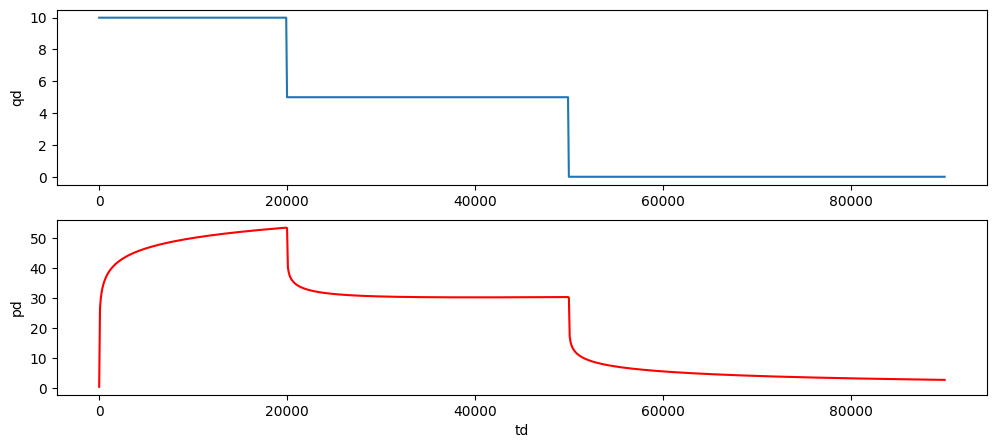

In [11]:
td_arr = np.linspace(1e-3, 9e4, 1000)


td_history = np.array([ 0., 2e4, 5e4 ], dtype=np.float64) 
qd_history = np.array([10., 5., 0.], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history), color='red') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()